<a id="setup"></a>
# Environment Setup & Configuration

In [1]:
from google.cloud import storage
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plot_timeseries as viz

import warnings
warnings.filterwarnings('ignore')

# set env variable to authenticate to gcp for cloud storage
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "storage_key.json"

In [2]:
# set plot figure size
plt.rcParams["figure.figsize"] = (9,6)

<a id="loading"></a>
# Data Loading

In [3]:
# --- Configuration ---
bucket_name = 'timeseries-ml-dataset'  #  GCS bucket name
source_blob_name = 'ml_dec_17.csv' # The name of the file in our GCS bucket
destination_file_name = 'ml_dec_17.csv' # The name we want for the downloaded file on your local disk/notebook environment

# --- Initialize client ---
storage_client = storage.Client()

# --- Get the bucket and blob (file) ---
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(source_blob_name)

# --- Download the file ---
try:
    blob.download_to_filename(destination_file_name)
    print(f"File {source_blob_name} downloaded to {destination_file_name}.")
    
except Exception as e:
    print(f"Error downloading file: {e}")

# --- we can now load the downloaded file with pandas ---
import pandas as pd
df = pd.read_csv(destination_file_name)
display(df.head())
print(f'Shape of dataset:{df.shape}')

File ml_dec_17.csv downloaded to ml_dec_17.csv.


,arrival_date,dow,duration,mbt
0,2024-01-01 00:34:05 UTC,0,24.02,NaN
1,2024-01-01 00:49:29 UTC,0,26.87,15.40
2,2024-01-01 01:02:10 UTC,0,28.02,12.68
3,2024-01-01 01:17:55 UTC,0,31.92,15.75
4,2024-01-01 01:34:17 UTC,0,31.03,16.37


Shape of dataset:(109917, 4)


In [4]:
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109917 entries, 0 to 109916
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   arrival_date  109917 non-null  datetime64[ns, UTC]
 1   dow           109917 non-null  int64              
 2   duration      109917 non-null  float64            
 3   mbt           109916 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1)
memory usage: 3.4 MB


### There are a small number of nulls, we will just remove them as we have a sufficiently dense sampling of arrival times over a 2 year period

<a id="cleaning"></a>
# Data Cleaning & Outlier Removal

### Outlier Analysis & Cleaning

We will perform the following steps:
1. **Remove Bad Data (Duration)**: Filter out rows with negative `duration` values.
2. **Remove Extreme Outliers (Duration)**: Filter out rows where `duration > 55` minutes. A duration > 55 mins implies a massive delay (e.g., 20+ mins in a tunnel), which is considered an error or non-representative event.
3. **Remove Extreme Outliers (MBT)**: Filter out rows where `mbt > 35` minutes. These represent ~4% of the data and are considered errors or non-useful extreme events.
4. **Analyze Distributions**: Inspect the cleaned data to decide on further transformations (e.g., Log Transform).

In [5]:
# duration
# 1. Remove Bad Data: Filter out negative duration instances
initial_count = len(df)
df = df[df['duration'] >= 0].copy()
print(f"Removed {initial_count - len(df)} rows with negative duration.")

# 2. Remove Extreme Outliers: Filter out duration > 150 minutes
# there are 30 instances of duration between 100 - 150 minutes from 2024 - 2025
upper_duration_bound = 55
initial_count = len(df)
df = df[df['duration'] <= upper_duration_bound].copy()
print(f"Removed {initial_count - len(df)} rows where duration > {upper_duration_bound} mins.")

# 3. Analyze distribution of outliers for duration
print("\n--- Duration Distribution (Outliers) ---")
# Display quantiles to see the spread, including extremes
print(df['duration'].quantile([0.0, 0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999, 1.0]))

Removed 17 rows with negative duration.
Removed 1546 rows where duration > 55 mins.

--- Duration Distribution (Outliers) ---
0.000     0.13
0.001    16.08
0.010    22.90
0.050    23.92
0.250    25.67
0.500    27.33
0.750    30.50
0.950    44.08
0.990    51.53
0.999    54.58
1.000    55.00
Name: duration, dtype: float64


In [6]:
# 3. Remove Extreme Outliers: Filter out mbt > 35 minutes
# User identified that > 35 mins is likely error/garbage data (approx 4% of data)
upper_bound = 35
initial_count = len(df)
df = df[df['mbt'] <= upper_bound].copy()
print(f"Removed {initial_count - len(df)} rows where mbt > {upper_bound} mins.")

Removed 438 rows where mbt > 35 mins.


In [ ]:
df.describe().T

In [ ]:
df.head()

<a id="eda"></a>
# Exploratory Data Analysis (EDA)
# Visualize Trends in Data

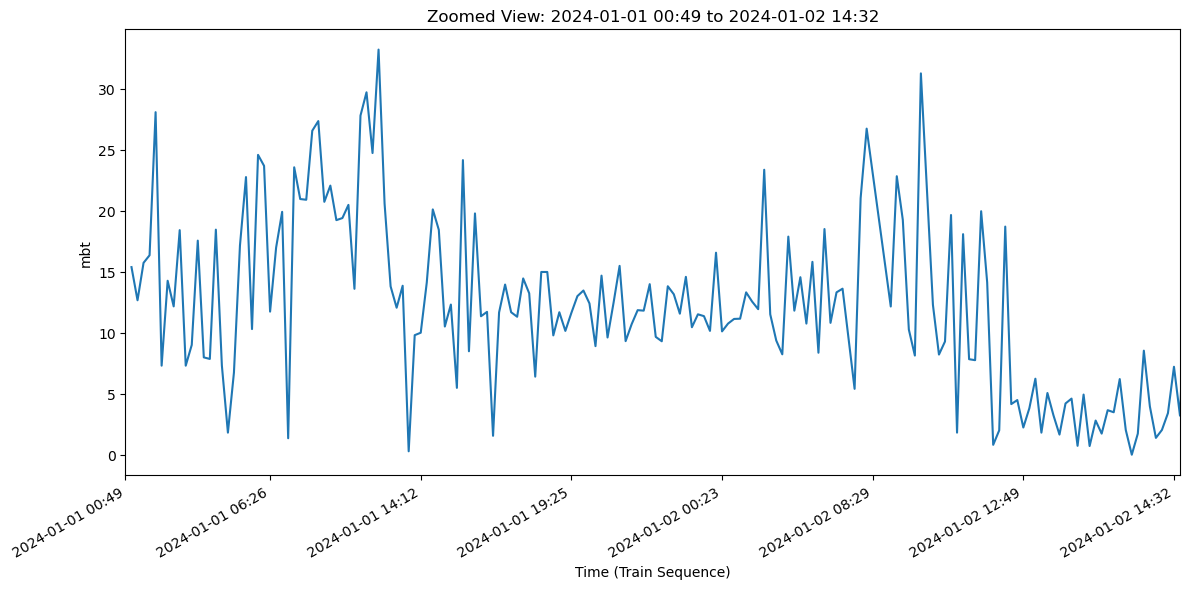

In [7]:
# sort the dates
#df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

viz.plot_zoomed_slice(df, 'mbt', start_idx=0, end_idx=175)

# The Heatmap (The "Fingerprint" of Transit)
This is the gold standard for transit data. It visualizes the schedule density by Time of Day vs. Day of Week. It will immediately reveal rush hours and weekend schedules.

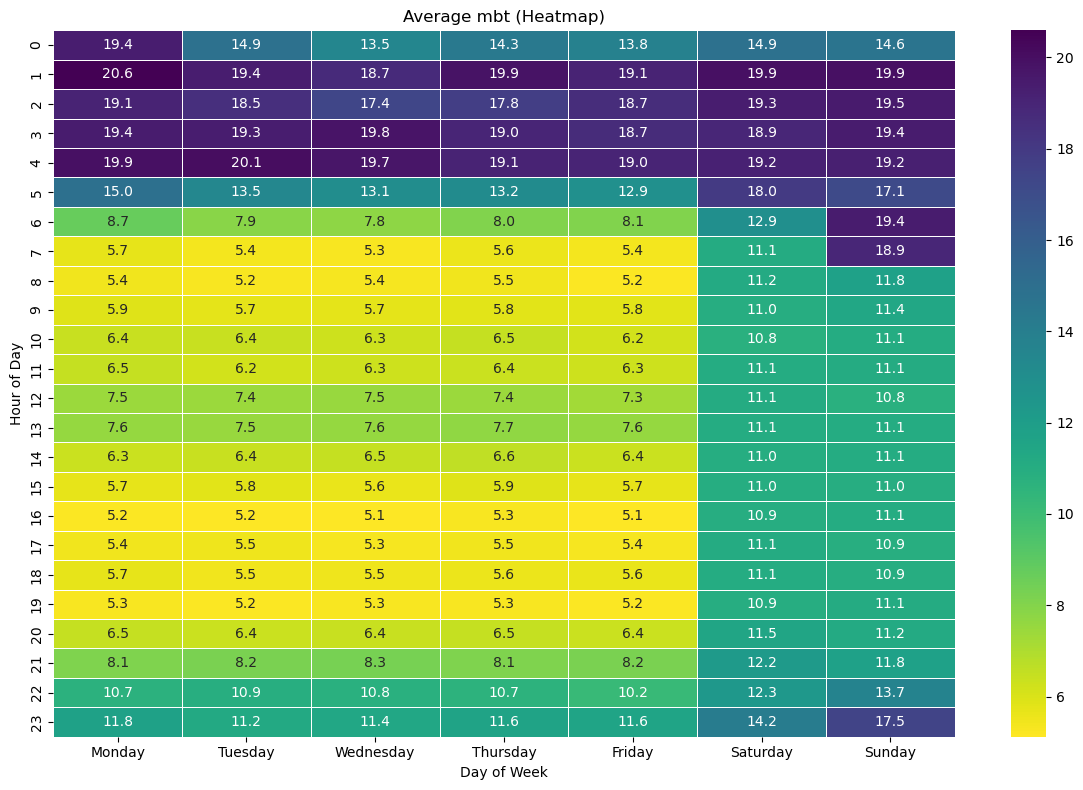

In [12]:
viz.plot_heatmap(df, 'mbt')

In [11]:
# Reload the updated plot_timeseries module
import importlib
importlib.reload(viz)

<module 'plot_timeseries' from '/Users/danherman/Desktop/nhits_gcp_workflow/training_and_preprocessing_workflows/plot_timeseries.py'>

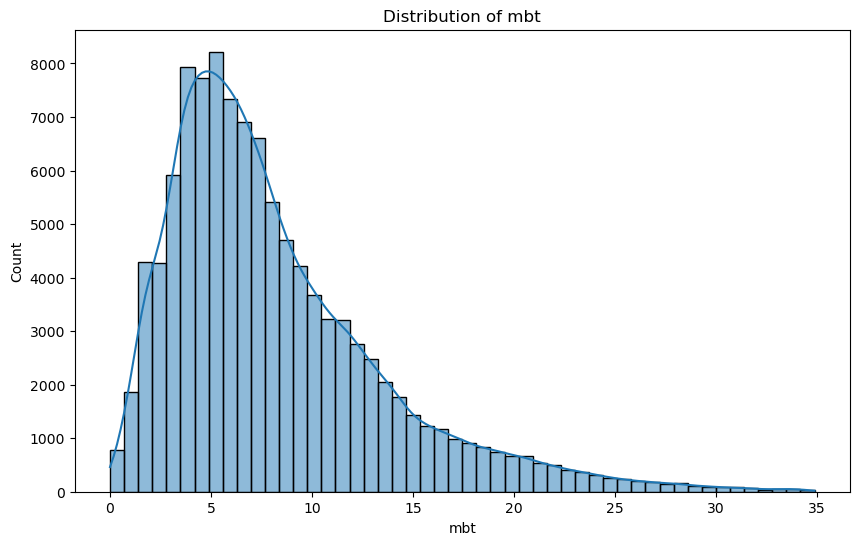

In [13]:
viz.plot_distribution(df, 'mbt')

<a id="nufft"></a>
# Spectral Analysis (NUFFT)
### Preprocessing using NUFFT (Non-Uniform Fast Fourier Transform)
To better understand the periodic patterns in our transit data, we will apply the Non-Uniform Fast Fourier Transform (NUFFT). This technique is particularly useful for analyzing time series data that may not be uniformly sampled, such as transit arrival times.

In [ ]:
from scipy.signal import lombscargle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from astropy.timeseries import LombScargle

# prepare data
if 'arrival_date' not in df.columns:
    print("Error: 'date' column required.")
else:
    # convert to days for astropy 
    t_days = (df['arrival_date'] - df['arrival_date'].min()).dt.total_seconds().values / (24 * 3600)
    y_signal = df['mbt'].values

    # compute periodogram (autoselects best frequencies)
    # autopower automatically determines the frequency grid and uses the fft method
    frequency, power = LombScargle(t_days, y_signal).autopower(minimum_frequency=1/365.25, maximum_frequency=24)

    # plot
    plt.figure(figsize=(10, 6))

    # convert frequency (cycles/day) to cycles/year for readability
    freq_per_year = frequency * 365.25

    plt.plot(freq_per_year, power)
    plt.xscale('log')

    # mark key periodicities
    plt.xticks([1, 52, 365.25], ['1/year', '1/week', '1/day'])

    plt.xlabel('Frequency (Cycles Per Year)')
    plt.ylabel('Power (Astropy Lomb-Scargle)')
    plt.title('Fast Spectral Analysis (Astorpy)')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

<a id="features"></a>
# Feature Engineering
Our spectral analysis confirmed strong periodicities at 1 day and 1 week, we should explicitly encode these cycles into our dataset.  Specifically, we will convert time features into cyclical features using sine and cosine transformations.<br>
<br>
Machine learning models (like LSTMs) struggle with raw time inputs (e.g., Hour 0 and Hour 23 look "far apart" numerically, but they are actually adjacent). The standard fix is to transform time into Cyclical Features using Sine and Cosine waves.<br>
<br>

In [ ]:
# convert timestamp to seconds to calculate precise angles
timestamp_s = df['arrival_date'].map(pd.Timestamp.timestamp)

# define periods in seconds
day = 24 * 60 * 60
week = 7 * day
year = (365.2425) * day

# 1. encode daily seasonality (captures rush hour vs. evening)
df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

# 2. encode weekly seasonality (captures weekday vs.weekend)
df['week_sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['week_cos'] = np.cos(timestamp_s * (2 * np.pi / week))

# --- NEW: Rolling Regime Features ---
# These features explicitly tell the model the "current speed" of the system.
# This helps the LSTM adjust its expectations for the next step based on recent history
# visualize to verify, zoom in on a few days
plt.figure(figsize=(14, 4))
# plotting first 1000 points (approx 1 week of data)
plt.plot(df['day_sin'][:1000], label='Day Sin', alpha=0.7)
plt.plot(df['week_sin'][:1000], label='Week Sin', linewidth=3)
plt.title("Cyclical Time Features (daily vs Weekly)")
plt.legend(loc='upper right')
plt.show()

# Weather Data Integration

Weather data is integrated into the ML pipeline to provide additional context for train arrival predictions. By merging weather features (such as temperature, precipitation, snow, visibility and wind speed) with the main dataset, the model can account for external factors that may influence train delays or arrival times. 
<br><br>
This integration is done by the hour, connecting hourly weather data to the closest arrival timestamp.  This procedure ensuring that each train event is enriched with the relevant weather conditions at that time and place. 

In [14]:
# --- WEATHER DATA INTEGRATION (REWRITTEN) ---

# 1. Load the weather data
weather_df = pd.read_csv('../weather_data.csv') 

# 2. Select only the physics-based features
weather_features = ['datetime', 'temp', 'precip', 'snow', 'snowdepth', 'visibility', 'windspeed']
weather_df = weather_df[weather_features].copy()

# 3. Convert weather timestamp to datetime objects
# FIX: Ensure UTC to avoid timezone mismatch errors during merge
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], utc=True)

# 4. FIX: Align Date Ranges
# Since weather data starts in 2024, we must drop older train data to avoid NaNs.
print(f"Original Train Count: {len(df)}")
df = df[df['arrival_date'] >= '2024-01-01'].copy()
print(f"Filtered Train Count (2024+): {len(df)}")

# 5. Create a "Join Key" in your Train Data
# Round train arrival time to the nearest hour to match weather data
# FIX: Ensure UTC for the join key
df['weather_join_key'] = pd.to_datetime(df['arrival_date'], utc=True).dt.round('h')

# 6. Merge
# Left join ensures we keep all train trips
df = pd.merge(df, weather_df, left_on='weather_join_key', right_on='datetime', how='left')

# 7. Clean up
# Forward fill missing weather data (small gaps)
weather_cols = ['temp', 'precip', 'snow', 'snowdepth', 'visibility', 'windspeed']
df[weather_cols] = df[weather_cols].fillna(method='ffill')

# Drop the helper columns (join key and the duplicate weather timestamp)
df.drop(columns=['weather_join_key', 'datetime'], inplace=True)

print("Merge Complete. New Shape:", df.shape)
display(df.head())

Original Train Count: 107916
Filtered Train Count (2024+): 107916
Merge Complete. New Shape: (107926, 10)


,arrival_date,dow,duration,mbt,temp,precip,snow,snowdepth,visibility,windspeed
0,2024-01-01 00:49:29+00:00,0,26.87,15.40,42.2,0.0,0.0,0.0,9.9,6.9
1,2024-01-01 01:02:10+00:00,0,28.02,12.68,42.2,0.0,0.0,0.0,9.9,6.9
2,2024-01-01 01:17:55+00:00,0,31.92,15.75,42.2,0.0,0.0,0.0,9.9,6.9
3,2024-01-01 01:34:17+00:00,0,31.03,16.37,42.2,0.0,0.0,0.0,9.9,5.0
4,2024-01-01 02:02:23+00:00,0,42.05,28.10,42.2,0.0,0.0,0.0,9.9,5.0


array([[<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'precip'}>],
       [<Axes: title={'center': 'snow'}>,
        <Axes: title={'center': 'snowdepth'}>],
       [<Axes: title={'center': 'visibility'}>,
        <Axes: title={'center': 'windspeed'}>]], dtype=object)

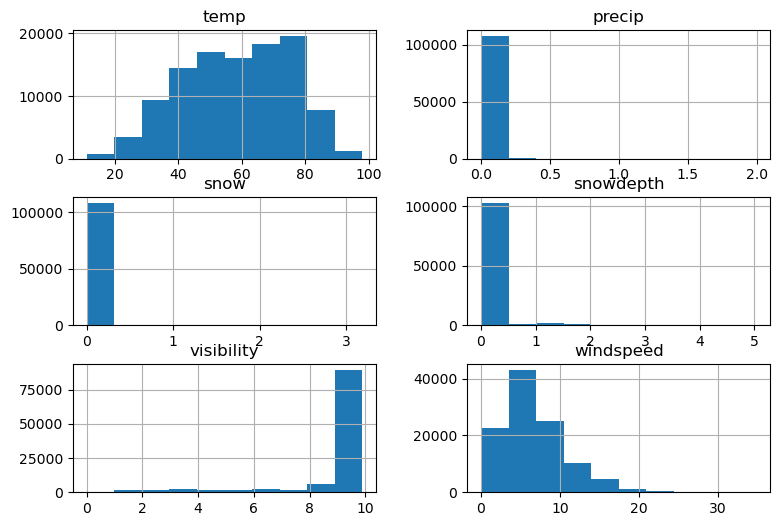

In [15]:
df.iloc[:, 4:].hist()

# Rolling Regime Features and Their Purpose

Rolling regime features are engineered to capture the recent behavioral patterns of the train system over a moving time window. These features typically include rolling averages, standard deviations, and other statistics calculated over a fixed number of previous time steps (e.g., the last 5 or 10 arrivals). <br><br>
The purpose of these regime features is to provide the model with information about short-term trends, volatility, and anomalies in train arrivals, which may not be evident from static features alone. 

In [16]:
# --- REAPPLY ROLLING REGIME FEATURES AFTER WEATHER MERGE ---

# These features should be recalculated after merging weather data, to ensure alignment with the final dataset.
 # 1. Rolling Features
# Calculate rolling std with window 50
df['rolling_std_50'] = df['mbt'].rolling(window=50).std().bfill()
# Add Rolling Max to capture recent spikes (delays)
df['rolling_max_10'] = df['mbt'].rolling(window=10).max().bfill()
# Add Rolling Mean/Std 10 (mentioned in prompt text of NHITS notebook)
df['rolling_mean_10'] = df['mbt'].rolling(window=10).mean().bfill()
df['rolling_std_10'] = df['mbt'].rolling(window=10).std().bfill()
df['rolling_mean_50'] = df['mbt'].rolling(window=50).mean().bfill()

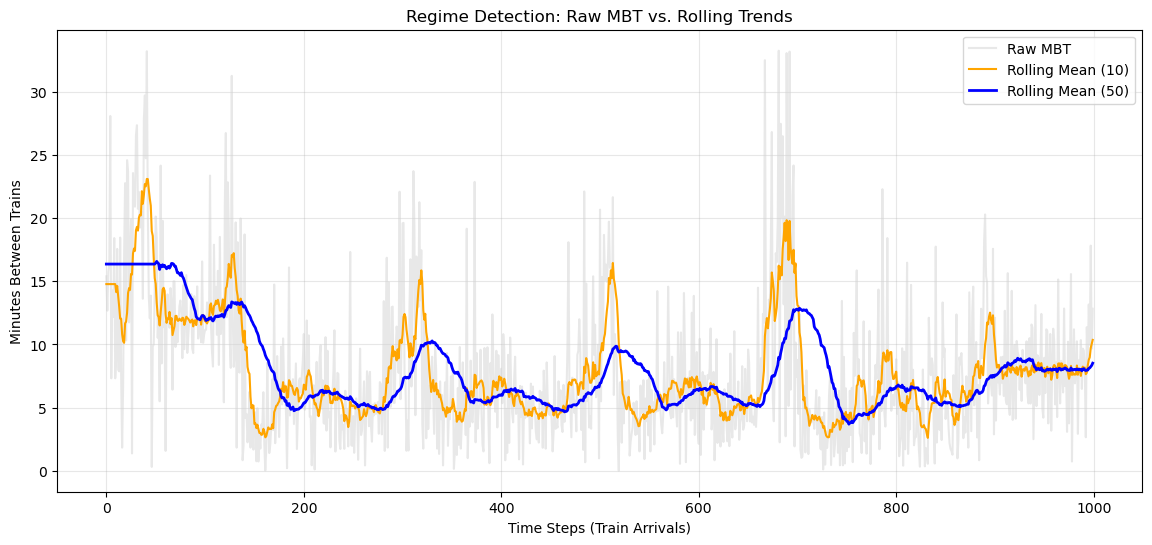

In [17]:
# ...existing code...
# visualize to verify, zoom in on a few days
plt.figure(figsize=(14, 6))

# Slice the first 1000 points (approx 1 week)
slice_idx = 1000
x_axis = range(slice_idx)

# 1. Plot Raw MBT (The noisy signal)
plt.plot(x_axis, df['mbt'][:slice_idx], label='Raw MBT', color='lightgray', alpha=0.5)

# 2. Plot Short-Term Trend (Window 10)
plt.plot(x_axis, df['rolling_mean_10'][:slice_idx], label='Rolling Mean (10)', color='orange', linewidth=1.5)

# 3. Plot Long-Term Trend (Window 50)
plt.plot(x_axis, df['rolling_mean_50'][:slice_idx], label='Rolling Mean (50)', color='blue', linewidth=2)

plt.title("Regime Detection: Raw MBT vs. Rolling Trends")
plt.ylabel("Minutes Between Trains")
plt.xlabel("Time Steps (Train Arrivals)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
df.head()

,arrival_date,dow,duration,mbt,temp,precip,snow,snowdepth,visibility,windspeed,rolling_std_50,rolling_max_10,rolling_mean_10,rolling_std_10,rolling_mean_50
0,2024-01-01 00:49:29+00:00,0,26.87,15.40,42.2,0.0,0.0,0.0,9.9,6.9,7.643376,28.1,14.783,5.937839,16.3698
1,2024-01-01 01:02:10+00:00,0,28.02,12.68,42.2,0.0,0.0,0.0,9.9,6.9,7.643376,28.1,14.783,5.937839,16.3698
2,2024-01-01 01:17:55+00:00,0,31.92,15.75,42.2,0.0,0.0,0.0,9.9,6.9,7.643376,28.1,14.783,5.937839,16.3698
3,2024-01-01 01:34:17+00:00,0,31.03,16.37,42.2,0.0,0.0,0.0,9.9,5.0,7.643376,28.1,14.783,5.937839,16.3698
4,2024-01-01 02:02:23+00:00,0,42.05,28.10,42.2,0.0,0.0,0.0,9.9,5.0,7.643376,28.1,14.783,5.937839,16.3698


In [19]:
# save dataset to ml_training_workflows

df.to_csv('../training_and_preprocessing_workflows/full_clean_ml_datset.csv', header=True, index=False)